In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/phylum/abs_muskegon_phylum_5in10_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/phylum/rel_muskegon_phylum_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [3]:
index = target.Lake[target.Lake == 'Muskegon'].index

In [4]:
'''Set sample names as index and shuffle data'''

#Remove outlier samples:
#data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[index,'HNA.cells']
hna_rel = hna/target.loc[index,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[index,'LNA.cells']
lna_rel = lna/target.loc[index,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [5]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [6]:
fs_scores = pd.read_csv('Final/FS_Scores/Muskegon_fs_scores_HNA_5seq10_phylum.csv', index_col=0)
fs_scores.sort_values('RL score', ascending=False, inplace=True)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = data_rel#composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = data_rel#pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [7]:
kendall = np.zeros(len(otus))
p_kendall = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    kendall[i], p_kendall[i] = kendalltau(data_rel_clr.loc[index_prod,otus[i]],prod)
fs = pd.DataFrame(kendall, index=otus, columns = ['kendall_prod'])
fs['p_kendall_prod'] = p_kendall
fs['kendall_significant_prod'] = np.where(fs.loc[otus,'p_kendall_prod']<0.05,'yes','no')

In [8]:
from statsmodels.sandbox.stats.multicomp import multipletests
fdr_bh = multipletests(p_kendall, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
display(fdr_bh[0])
fs['fdr_bh'] = fdr_bh[1]

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [9]:
fs_prod = pd.concat([fs_scores,fs], axis=1)
fs_prod.sort_values('p_kendall_prod', inplace=True, ascending=True)
display(fs_prod)

,f_regr,p-value,kendall,p_kendall,kendall significant,RL score,RL ranking,Boruta score,Boruta ranking,kendall_prod,p_kendall_prod,kendall_significant_prod,fdr_bh
Otu000010,0.436170,0.511504,0.084082,0.334155,no,0.998,1.0,0.013325,7,0.568421,0.000458,yes,0.010084
Otu000075,12.716387,0.000719,-0.311475,0.000347,yes,0.958,12.0,0.073534,3,-0.442105,0.006424,yes,0.070663
Otu000082,1.135182,0.290941,-0.075621,0.385069,no,0.962,9.0,0.014499,8,-0.346697,0.034413,yes,0.252364
Otu000004,0.000132,0.990856,0.018509,0.831645,no,0.988,4.0,0.007238,14,-0.243390,0.135173,no,0.647650
Otu000931,1.319494,0.255242,0.113696,0.191577,no,0.962,9.0,0.012753,10,-0.234420,0.170537,no,0.647650
Otu001487,0.825928,0.367089,0.096774,0.266329,no,0.950,14.0,0.007208,15,-0.253917,0.185877,no,0.647650
Otu001021,2.068552,0.155560,0.099947,0.250968,no,0.938,17.0,0.017445,4,-0.226608,0.232275,no,0.647650
Otu000009,13.455162,0.000520,0.295611,0.000685,yes,0.996,2.0,0.145125,1,0.189474,0.242809,no,0.647650
Otu000682,1.459510,0.231748,0.224749,0.009838,yes,0.962,9.0,0.083604,2,0.193460,0.264948,no,0.647650
Otu000227,0.231227,0.632364,0.029085,0.738323,no,0.946,15.0,0.004820,20,0.142181,0.394742,no,0.786466


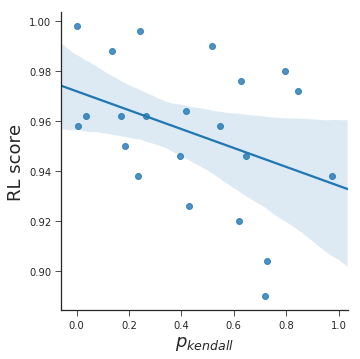

In [10]:
g = sns.lmplot(x='p_kendall_prod',y='RL score',data=fs_prod, fit_reg=True)
g.set_titles(size=22)
g.set_xlabels(r'$p_{kendall}$',fontsize=18)
g.set_ylabels(fontsize=18)
#g.fig.get_axes()[0].set_yscale('log')
plt.show()

In [11]:
#fs.to_csv('Muskegon_fs_scores_HNA_5seq10_phylum_prod.csv')

In [12]:
display(data_rel_clr.loc[index_prod,'Otu001846'])

samples
MBRE2F515    0.001559
MBRE1F714    0.000000
MBRE1F715    0.001113
MBRE1F914    0.000223
MBRE2F915    0.000000
MDPE1F514    0.000668
MDPE2F515    0.001559
MDPE1F714    0.000000
MDPE1F715    0.000445
MDPE1F914    0.000223
MDPE2F915    0.000000
MINE1F715    0.000445
MINE1F914    0.000000
MINE2F915    0.000445
MOTE1F514    0.000891
MOTE2F515    0.000223
MOTE1F714    0.000000
MOTE1F715    0.000891
MOTE1F914    0.000668
MOTE2F915    0.000000
Name: Otu001846, dtype: float64